# RL Assignment

### Roberto Forner

In [60]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
import time

## Useful Functions

In [61]:
def game_render(agent, height=15, width=20, pipe_gap=4):
    env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
    obs, _ = env.reset()
    done = False

    while not done:
        action = agent.trained_agent_policy(obs)

        obs, reward, done, _, info = env.step(action)

        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2)

    env.close()


def argmax(q_vals):
    top = float("-inf")
    ties = []

    for q in range(len(q_vals)):
        if q_vals[q] > top:
            top = q_vals[q]
            ties = []

        if q_vals[q] == top:
            ties.append(q)

    return np.random.choice(ties)


## Monte Carlo Agent

In [62]:
class MC_Agent:
    
    def __init__(self):
        self.eps = None
        self.weights = None
        self.alpha = None
        self.gamma = None
        self.init_weights = None
        self.n_actions = None
        self.state_space = None
        self.final_return = None
    
    def initialize_agent(self, agent_info={}):
        self.eps = agent_info.get("eps", 0.05)
        self.alpha = agent_info.get("alpha", 0.5)
        self.gamma = agent_info.get("gamma", 0.9)
        self.init_weights = agent_info.get("init_weights", float(0))
        self.n_actions = agent_info.get("n_actions", 2)
        self.state_space = agent_info.get("state_space", (14, 22))
        
        self.weights = np.ones((self.n_actions, self.state_space[0], self.state_space[1])) * self.init_weights
        
    
    # Action choice with epsilon-greedy strategy
    def policy(self, state):
        
        dx, dy = state
        action_vals = self.weights[:, dx, dy]
        
        if np.random.random() < self.eps:
            action_choice = np.random.randint(self.n_actions)
        else:
            action_choice = argmax(action_vals)
        
        return action_choice, action_vals[action_choice]
    

    # Action choice with a greedy strategy with a trained agent
    def trained_agent_policy(self, state):
        
        dx, dy = state
        action_vals = self.weights[:, dx, dy]
        action_choice = argmax(action_vals)
        return action_choice
    

    def generate_episode(self, env):
        
        episode = []
        state, _ = env.reset()
        score = 0
        done = False
        while not done:
            action, _ = self.policy(state)
            next_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward))
            score = info["score"]
            state = next_state
        return episode, score
    
    
    # Update weights through MC 
    def update_weights(self, episode):
        
        states, actions, rewards = zip(*episode)
        
        discounts = np.array([self.gamma ** i for i in range(len(rewards) + 1)])
        for i, states, in enumerate(states):
            G_t = sum(rewards[i:] * discounts[:-(1+i)])
            self.weights[actions[i]][states[0]][states[1]] += self.alpha * (G_t - self.weights[actions[i]][states[0]][states[1]])

In [63]:
n_runs = 3
n_episodes = 7000

In [64]:
# Training Phase
mc_agent = MC_Agent()
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

mc_agent_steps = []
mc_agent_scores = []
mc_agents_weights = []

for run in range(n_runs):
    
    mc_agent.initialize_agent()
    eps_steps = []
    eps_score = []

    for ep in tqdm(range(n_episodes)):
        episode, score = mc_agent.generate_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
        mc_agent.update_weights(episode)

    mc_agent_steps.append(np.array(eps_steps))
    mc_agent_scores.append(np.array(eps_score))
    mc_agents_weights.append(np.array(mc_agent.weights))

mc_avg_steps = np.mean(mc_agent_steps, axis=0)
mc_avg_scores = np.mean(mc_agent_scores, axis=0)
mc_avg_weights = np.mean(mc_agents_weights, axis=0)

  0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 7000/7000 [00:10<00:00, 675.61it/s] 


In [65]:
print("\t    MC Results")
print("----------------------------------")
print("| Average Steps\t | Average Score |")
print("----------------------------------")
print(f"| {np.mean(mc_avg_steps):.3f} \t | {np.mean(mc_avg_scores):.3f} \t |")
print("----------------------------------")

	    MC Results
----------------------------------
| Average Steps	 | Average Score |
----------------------------------
| 89.781 	 | 7.791 	 |
----------------------------------


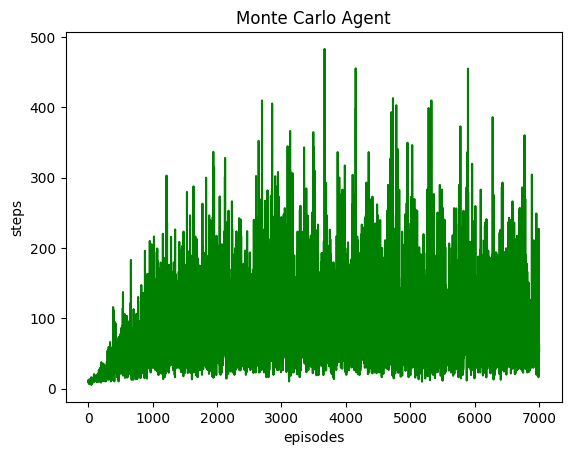

In [153]:
plt.plot(mc_avg_steps, color='green')
plt.title("Monte Carlo Agent")
plt.xlabel("episodes")
plt.ylabel("steps")
# plt.savefig("Res_Plots/MC_run1/steps_per_episode_mc.png", dpi=300)
plt.show()

In [67]:
# Graph initialization
x = np.arange(0, 14, dtype="int")
y1 = [i for i in range(11, 0, -1)]
y2 = [-i for i in range(0, 12)]
y = y1 + y2
X, Y = np.meshgrid(x, y)

In [68]:
V = np.max(mc_avg_weights, axis=0)

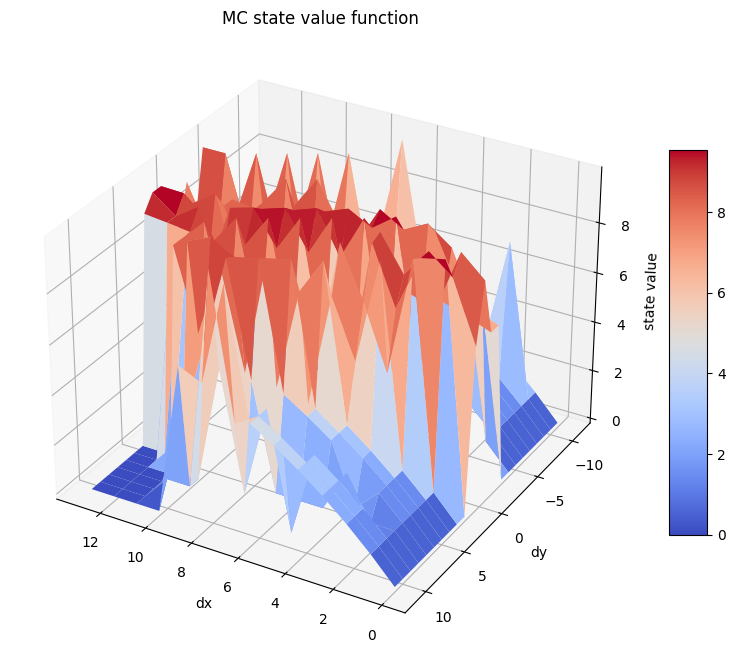

In [126]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_zlabel("state value")
ax.set_title("MC state value function")
ax.view_init(ax.elev, 120)
surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
#plt.savefig("Res_Plots/MC_run1/state_value_function_mc.png", dpi=300)
plt.show()

In [70]:
# uncomment to run a text rendered example
# game_render(mc_agent)

### Exploring Parameters

In [71]:
alphas = [i/10 for i in range(1, 11)]
gammas = [i/10 for i in range(1, 11)]

In [72]:
mc_alphas_steps = {}
mc_alphas_scores = {}
mc_alphas_weights = {}

for a in alphas:
    mc_agent_alphaexp = MC_Agent()
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    mc_agent_alphaexp.initialize_agent({"alpha": a})
    eps_steps = []
    eps_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = mc_agent_alphaexp.generate_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
        mc_agent_alphaexp.update_weights(episode)
    mc_alphas_steps[a] = np.array(eps_steps)
    mc_alphas_scores[a] = np.array(eps_score)
    mc_alphas_weights[a] = np.array(mc_agent_alphaexp.weights)

100%|██████████| 7000/7000 [00:02<00:00, 2690.43it/s]


In [73]:
print("Results of Parameter Exploration of Alpha (MC)")
print("------------------------------------------")
print("| Alpha  | Average Steps | Average Score |")
print("------------------------------------------")
for alpha in alphas:
    print(f"| {alpha} \t | {np.mean(mc_alphas_steps[alpha]):.3f} \t | {np.mean(mc_alphas_scores[alpha]):.3f} \t |")
print("------------------------------------------")

Results of Parameter Exploration of Alpha (MC)
------------------------------------------
| Alpha  | Average Steps | Average Score |
------------------------------------------
| 0.1 	 | 113.047 	 | 10.159 	 |
| 0.2 	 | 97.113 	 | 8.512 	 |
| 0.3 	 | 122.389 	 | 11.060 	 |
| 0.4 	 | 100.439 	 | 8.862 	 |
| 0.5 	 | 94.681 	 | 8.294 	 |
| 0.6 	 | 62.724 	 | 5.062 	 |
| 0.7 	 | 79.919 	 | 6.787 	 |
| 0.8 	 | 65.086 	 | 5.297 	 |
| 0.9 	 | 48.273 	 | 3.597 	 |
| 1.0 	 | 28.638 	 | 1.614 	 |
------------------------------------------


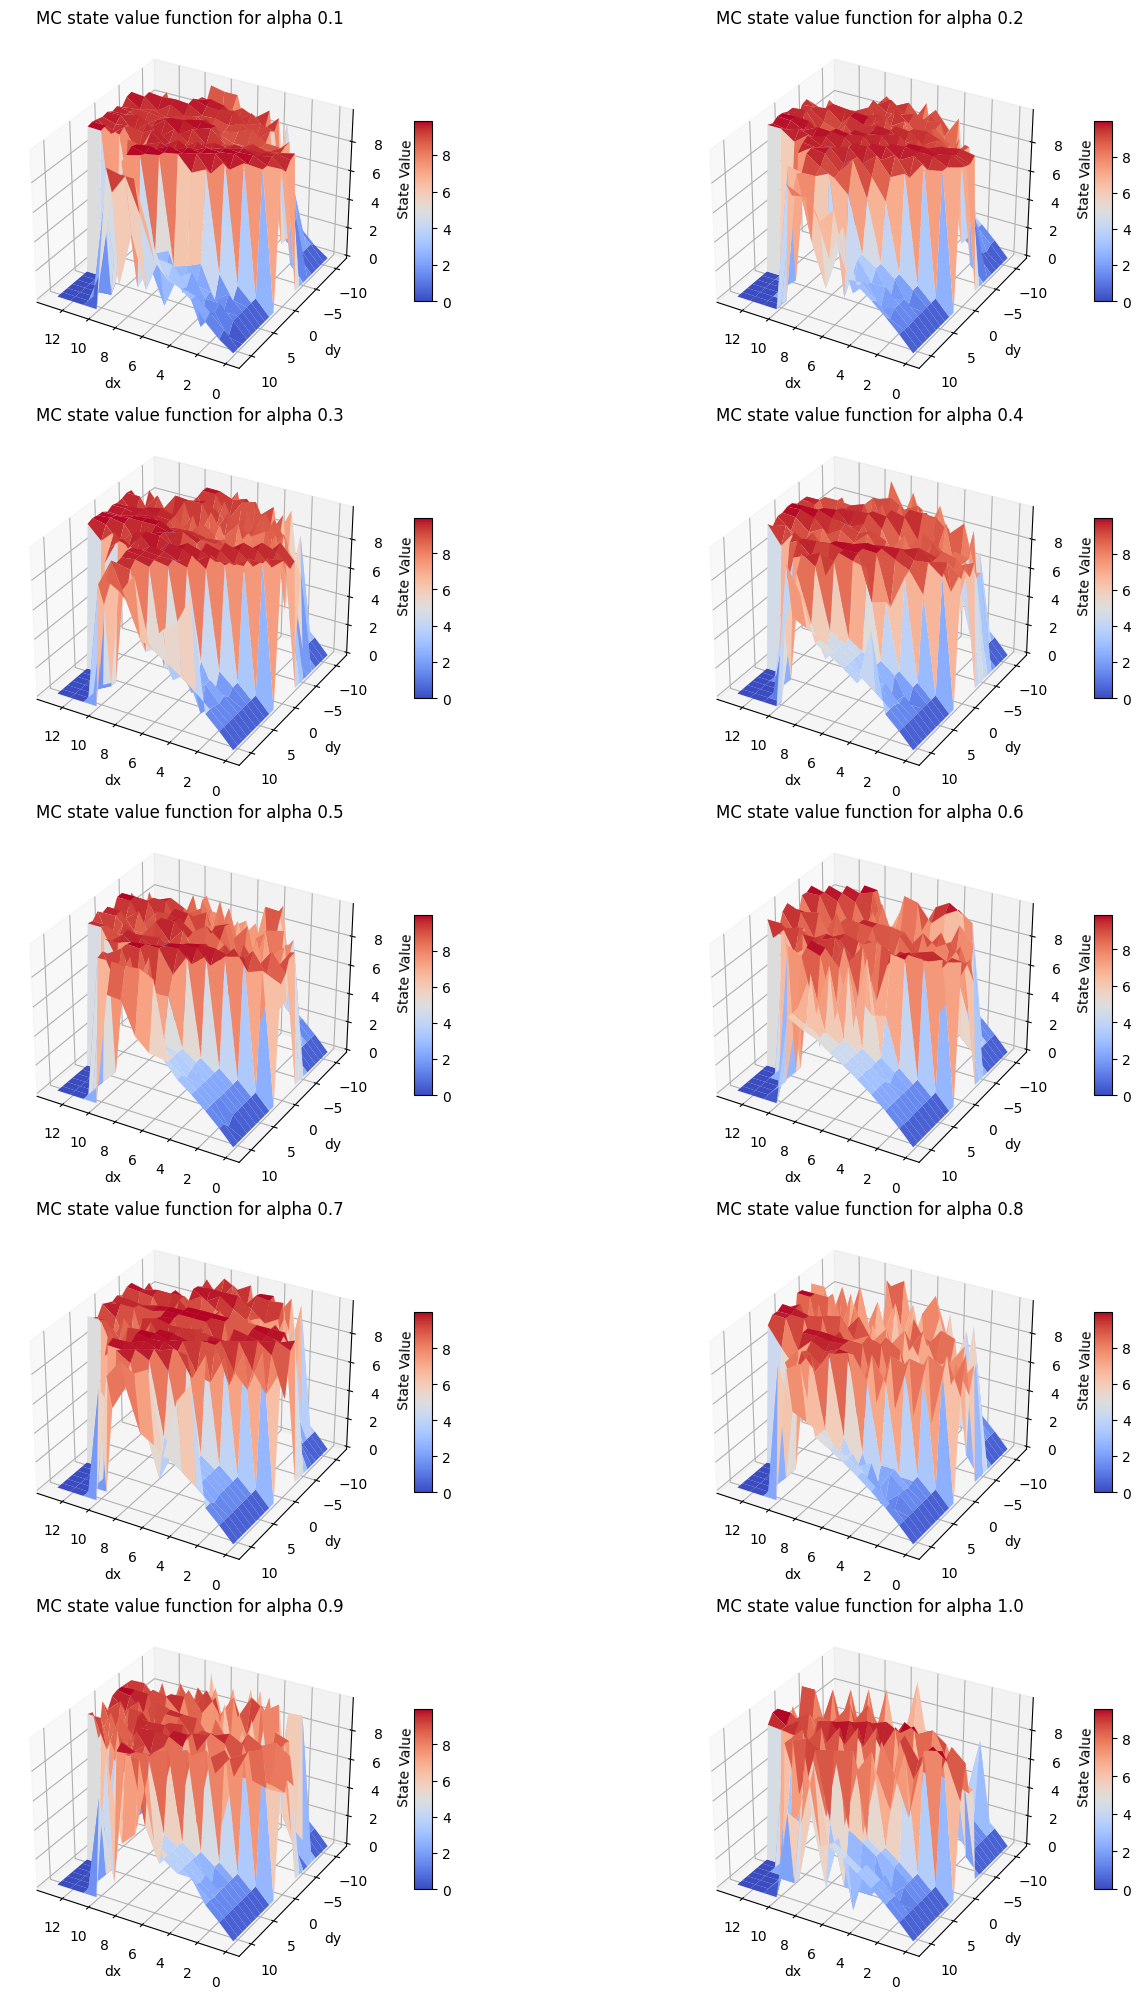

In [147]:
fig, axs = plt.subplots(5, 2, figsize=(16, 20), subplot_kw={'projection': '3d'})
axs = axs.flatten()  

for i, al in enumerate(alphas):
    V = np.max(mc_alphas_weights[al], axis=0)
    ax = axs[i]
    ax.set_xlabel("dx")
    ax.set_ylabel("dy")
    ax.set_zlabel("State Value")
    ax.set_title(f"MC state value function for alpha {al}")
    ax.view_init(ax.elev, 120)
    surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

In [75]:
mc_gammas_steps = {}
mc_gammas_scores = {}
mc_gammas_weights = {}

for g in gammas:
    mc_agent_gamma = MC_Agent()
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    mc_agent_gamma.initialize_agent({"gamma": g})
    eps_steps = []
    eps_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = mc_agent_gamma.generate_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
        mc_agent_gamma.update_weights(episode)
    mc_gammas_steps[g] = np.array(eps_steps)
    mc_gammas_scores[g] = np.array(eps_score)
    mc_gammas_weights[g] = np.array(mc_agent_gamma.weights)

100%|██████████| 7000/7000 [00:08<00:00, 861.23it/s] 


In [76]:
print("Results of Parameter Exploration of Gamma (MC)")
print("------------------------------------------")
print("| Gamma  | Average Steps | Average Score |")
print("------------------------------------------")
for gamma in gammas:
    print(f"| {gamma} \t | {np.mean(mc_gammas_steps[gamma]):.3f} \t | {np.mean(mc_gammas_scores[gamma]):.3f} \t |")
print("------------------------------------------")

Results of Parameter Exploration of Gamma (MC)
------------------------------------------
| Gamma  | Average Steps | Average Score |
------------------------------------------
| 0.1 	 | 37.680 	 | 2.556 	 |
| 0.2 	 | 39.080 	 | 2.651 	 |
| 0.3 	 | 61.201 	 | 4.882 	 |
| 0.4 	 | 44.807 	 | 3.256 	 |
| 0.5 	 | 44.881 	 | 3.236 	 |
| 0.6 	 | 56.874 	 | 4.433 	 |
| 0.7 	 | 75.215 	 | 6.279 	 |
| 0.8 	 | 81.267 	 | 6.906 	 |
| 0.9 	 | 97.170 	 | 8.541 	 |
| 1.0 	 | 71.125 	 | 5.996 	 |
------------------------------------------


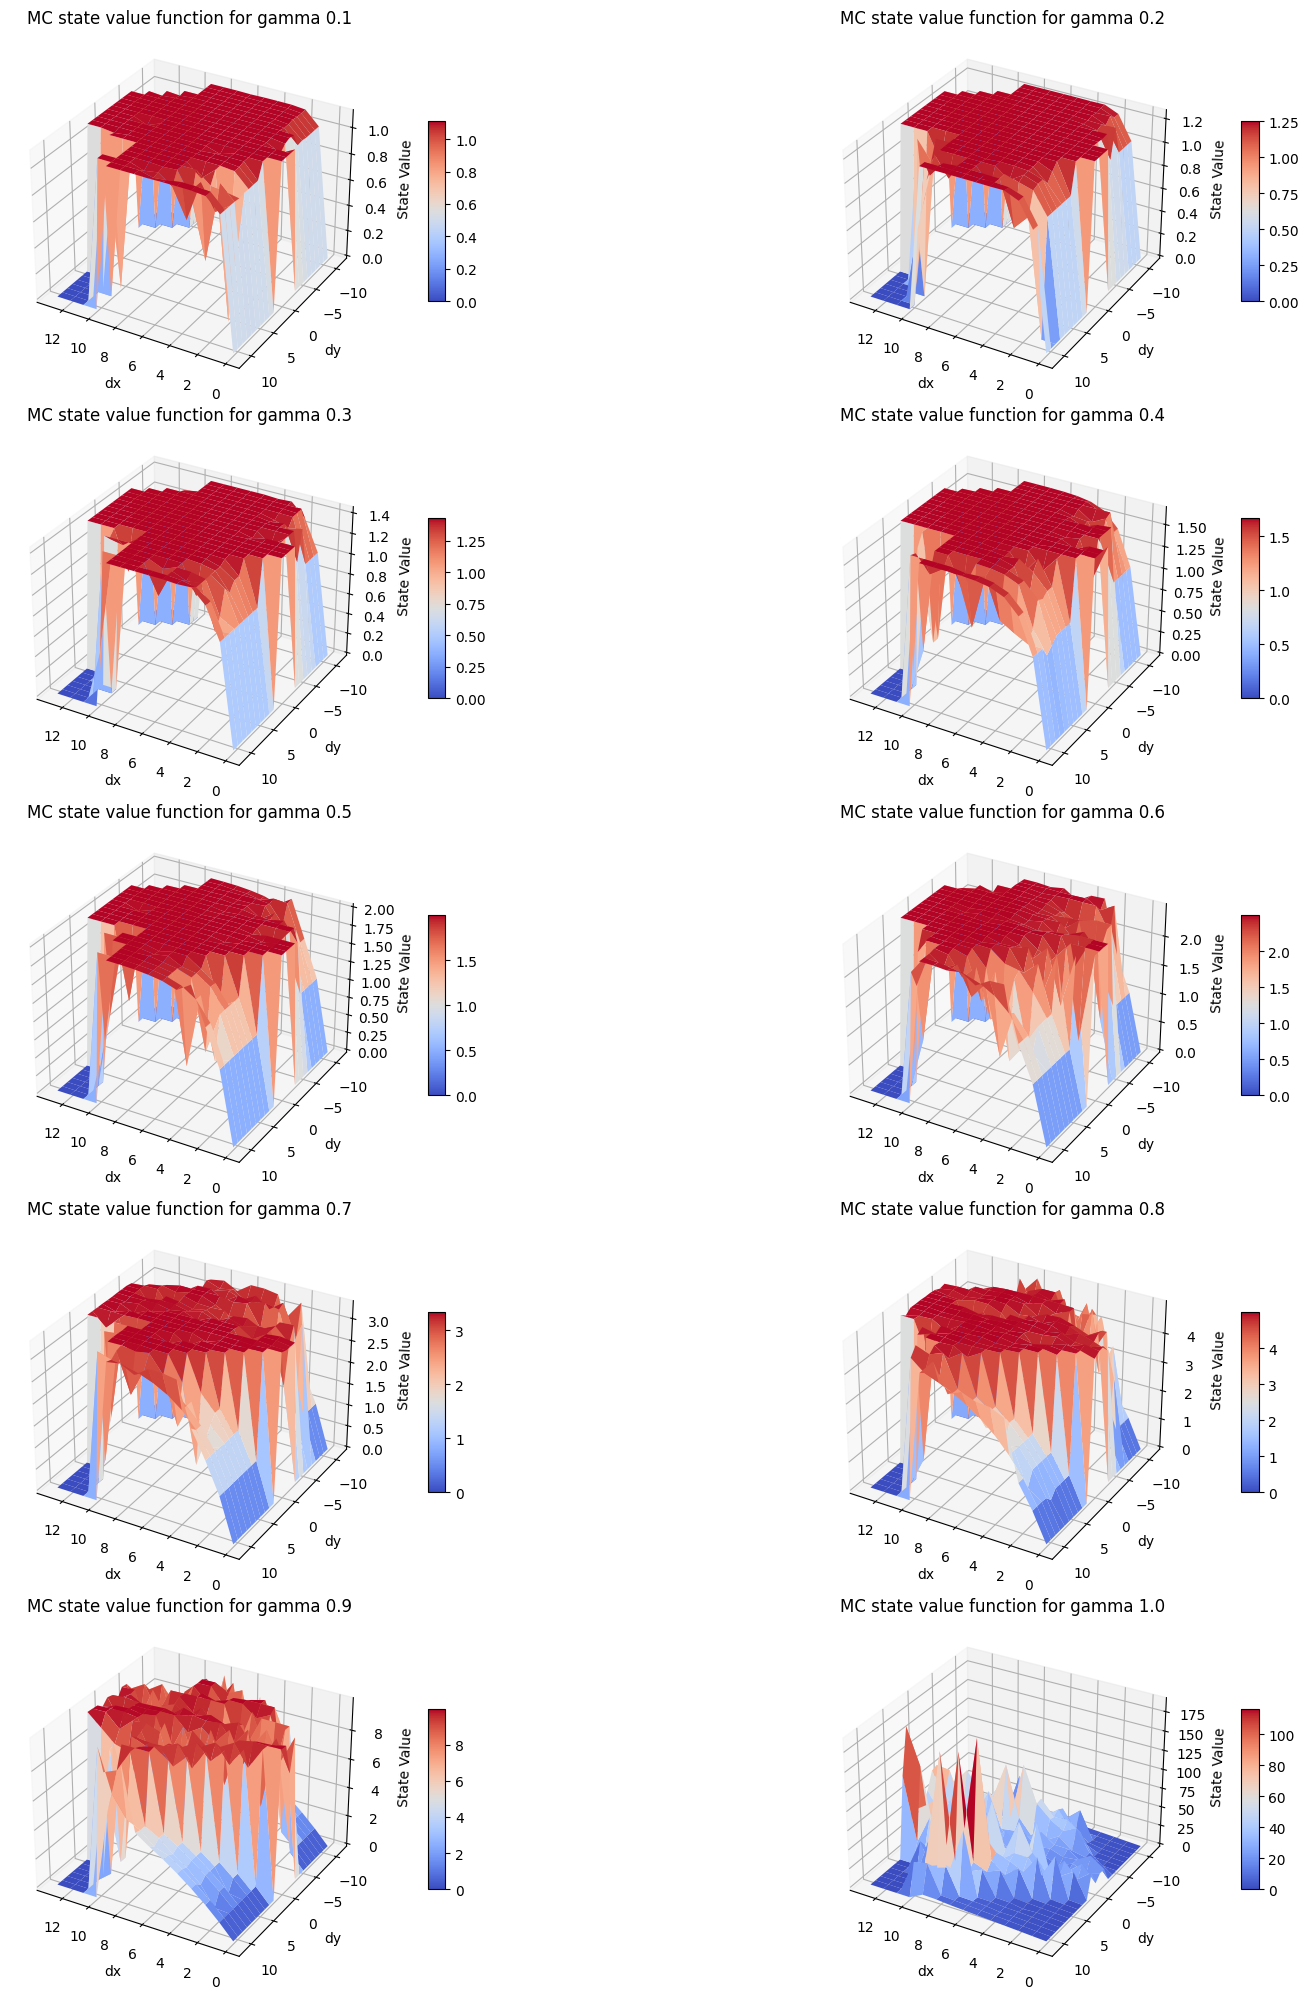

In [124]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})
axs = axs.flatten() 

for i, g in enumerate(gammas):
    V = np.max(mc_gammas_weights[g], axis=0)
    ax = axs[i]
    ax.set_xlabel("dx")
    ax.set_ylabel("dy")
    ax.set_zlabel("State Value")
    ax.set_title(f"MC state value function for gamma {g}")
    ax.view_init(ax.elev, 120)
    surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

## Sarsa($\lambda$)

In [20]:
class Sarsa_Lambda_Agent:
    
    def __init__(self):
        super().__init__()
        self.past_action = None
        self.past_state = None
        self.eps = None
        self.weights = None
        self.z = None
        self.alpha = None
        self.gamma = None
        self.lam = None
        self.init_weights = None
        self.n_actions = None
        self.state_space = None
        self.final_return = None
    
    def initialize_agent(self, agent_info={}):
        self.eps = agent_info.get("eps", 0.05)
        self.alpha = agent_info.get("alpha", 0.5)
        self.gamma = agent_info.get("gamma", 0.9)
        self.lbda = agent_info.get("lbda", 0.5)
        self.init_weights = agent_info.get("init_weights", 0.0)
        self.n_actions = agent_info.get("n_actions", 2)
        self.state_space = agent_info.get("state_space", (14, 22))
        
        self.weights = np.ones((self.n_actions, self.state_space[0], self.state_space[1])) * self.init_weights
        self.z = np.ones((self.n_actions, self.state_space[0], self.state_space[1])) * self.init_weights
    
    # Action choice with e-greedy strategy
    def policy(self, state):

        dx, dy = state
        action_values = self.weights[:, dx, dy]
        
        if np.random.random() < self.eps:
            chosen_action = np.random.randint(self.n_actions)
        else:
            chosen_action = argmax(action_values)
        
        return chosen_action, action_values[chosen_action]
    
    # Action choice with a greedy strategy with a trained agent
    def trained_agent_policy(self, state):

        dx, dy = state
        action_values = self.weights[:, dx, dy]
        chosen_action = argmax(action_values)
        return chosen_action
    
    
    def agent_start(self, state):
        present_action, _ = self.policy(state)
        self.past_action = present_action
        self.past_state = state
        self.z *= 0
        return self.past_action
    
    
    def agent_step(self, reward, state):
        present_action, action_value = self.policy(state)
        
        past_state_weights = self.weights[self.past_action][self.past_state[0]][self.past_state[1]]
        current_state_weights = self.weights[present_action][state[0]][state[1]]
        delta = reward + self.gamma * current_state_weights - past_state_weights
        self.z[self.past_action][self.past_state[0]][self.past_state[1]] += 1
        
        self.weights[:, self.past_state[0], self.past_state[1]] += self.alpha * delta * self.z[:, self.past_state[0], self.past_state[1]]
        
        self.z[:, self.past_state[0], self.past_state[1]] *= self.gamma * self.lbda
        
        self.past_action = present_action
        self.past_state = state
        
        return self.past_action
    
    def agent_end(self, reward):
        past_state_weights = self.weights[self.past_action][self.past_state[0]][self.past_state[1]]
        
        delta = reward - past_state_weights
        self.z[self.past_action][self.past_state[0]][self.past_state[1]] += 1
        self.weights[:, self.past_state[0], self.past_state[1]] += self.alpha * delta * self.z[:, self.past_state[0], self.past_state[1]]
    
    # Running an episode + update w with agent_start, agent_step, agent_end 
    def run_episode(self, env):

        episode = []
        state, _ = env.reset()
        action = self.agent_start(state)
        future_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))
        score = info["score"]
        state = future_state
        
        while not done:
            action = self.agent_step(reward, state)
            future_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward))
            score = info["score"]
            state = future_state
        
        self.agent_end(reward)
        
        return episode, score

In [22]:
# Training Process
sarsa_agent = Sarsa_Lambda_Agent()
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

sarsa_agent_steps = []
sarsa_agent_scores = []
sarsa_agent_weights = []

for run in range(n_runs):
    sarsa_agent.initialize_agent()
    eps_steps = []
    eps_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = sarsa_agent.run_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
    sarsa_agent_steps.append(np.array(eps_steps))
    sarsa_agent_scores.append(np.array(eps_score))
    sarsa_agent_weights.append(np.array(sarsa_agent.weights))

mean_steps_sarsa = np.mean(sarsa_agent_steps, axis=0)
mean_scores_sarsa = np.mean(sarsa_agent_scores, axis=0)
mean_weights_sarsa = np.mean(sarsa_agent_weights, axis=0)

100%|██████████| 7000/7000 [00:07<00:00, 966.19it/s] 


In [45]:
print("\tSarsa(lamba) Results")
print("----------------------------------")
print("| Average Steps\t | Average Score |")
print("----------------------------------")
print(f"| {np.mean(mean_steps_sarsa):.3f} \t | {np.mean(mean_scores_sarsa):.3f} \t |")
print("----------------------------------")

	Sarsa(lamba) Results
----------------------------------
| Average Steps	 | Average Score |
----------------------------------
| 78.351 	 | 6.674 	 |
----------------------------------


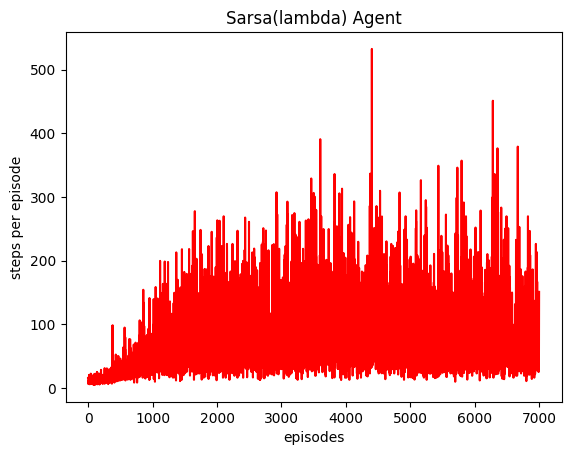

In [154]:

plt.plot(mean_steps_sarsa, color='red')
plt.title("Sarsa(lambda) Agent")
plt.xlabel("episodes")
plt.ylabel("steps per episode")
# plt.savefig("Res_Plots/Sarsa_run1/steps_per_episode_sarsa.png", dpi=300)
plt.show()

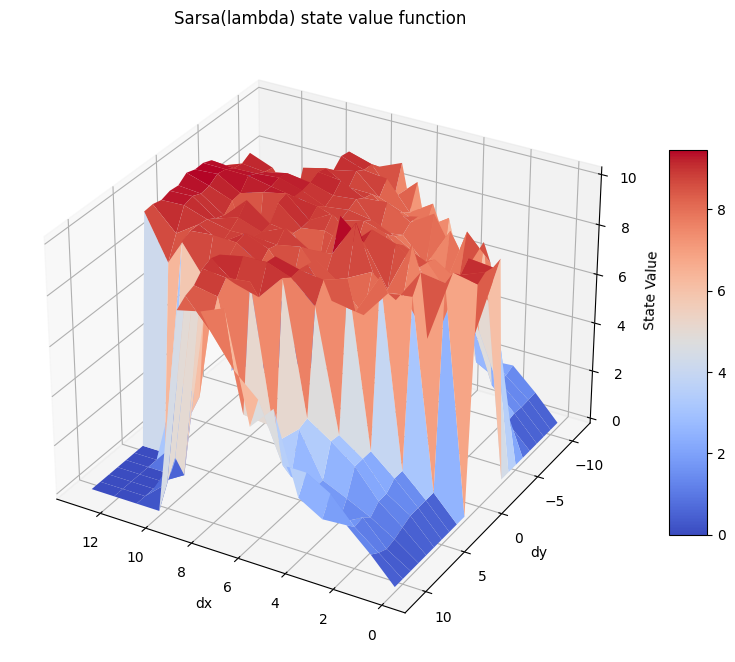

In [123]:
V = np.max(mean_weights_sarsa, axis=0)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_zlabel("State Value")
ax.set_title("Sarsa(lambda) state value function")
ax.view_init(ax.elev, 120)
surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
# plt.savefig("Res_Plots/Sarsa_run1/state_value_function_sarsa.png", dpi=300)
plt.show()

In [105]:
# uncomment to run a text rendered example
# game_render(agent_sarsa)

### Exploring Parameters

In [85]:
lambdas = [i/10 for i in range(1, 11)]
alphas = [i/10 for i in range(1, 11)]
gammas = [i/10 for i in range(1, 11)]

In [86]:
sarsa_alphas_steps = {}
sarsa_alphas_scores = {}
sarsa_alphas_weights = {}

for a in alphas:
    sarsa_agent_alpha = Sarsa_Lambda_Agent()
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    sarsa_agent_alpha.initialize_agent({"alpha": a})
    ep_steps = []
    ep_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = sarsa_agent_alpha.run_episode(env)
        ep_steps.append(len(episode))
        ep_score.append(score)
    sarsa_alphas_steps[a] = np.array(ep_steps)
    sarsa_alphas_scores[a] = np.array(ep_score)
    sarsa_alphas_weights[a] = np.array(sarsa_agent_alpha.weights)

100%|██████████| 7000/7000 [00:01<00:00, 5243.84it/s]


In [97]:
print("Results of Parameter Exploration of Alpha (Sarsa Lambda)")
print("------------------------------------------")
print("| Alpha  | Average Steps | Average Score |")
print("------------------------------------------")
for alpha in alphas:
    print(f"| {alpha} \t | {np.mean(sarsa_alphas_steps[alpha]):.3f} \t | {np.mean(sarsa_alphas_scores[alpha]):.3f} \t |")
print("------------------------------------------")

Results of Parameter Exploration of Alpha (Sarsa Lambda)
------------------------------------------
| Alpha  | Average Steps | Average Score |
------------------------------------------
| 0.1 	 | 30.804 	 | 2.073 	 |
| 0.2 	 | 90.509 	 | 7.974 	 |
| 0.3 	 | 103.929 	 | 9.225 	 |
| 0.4 	 | 87.752 	 | 7.648 	 |
| 0.5 	 | 77.904 	 | 6.622 	 |
| 0.6 	 | 48.970 	 | 3.711 	 |
| 0.7 	 | 31.633 	 | 1.961 	 |
| 0.8 	 | 23.957 	 | 1.189 	 |
| 0.9 	 | 19.590 	 | 0.744 	 |
| 1.0 	 | 15.557 	 | 0.346 	 |
------------------------------------------


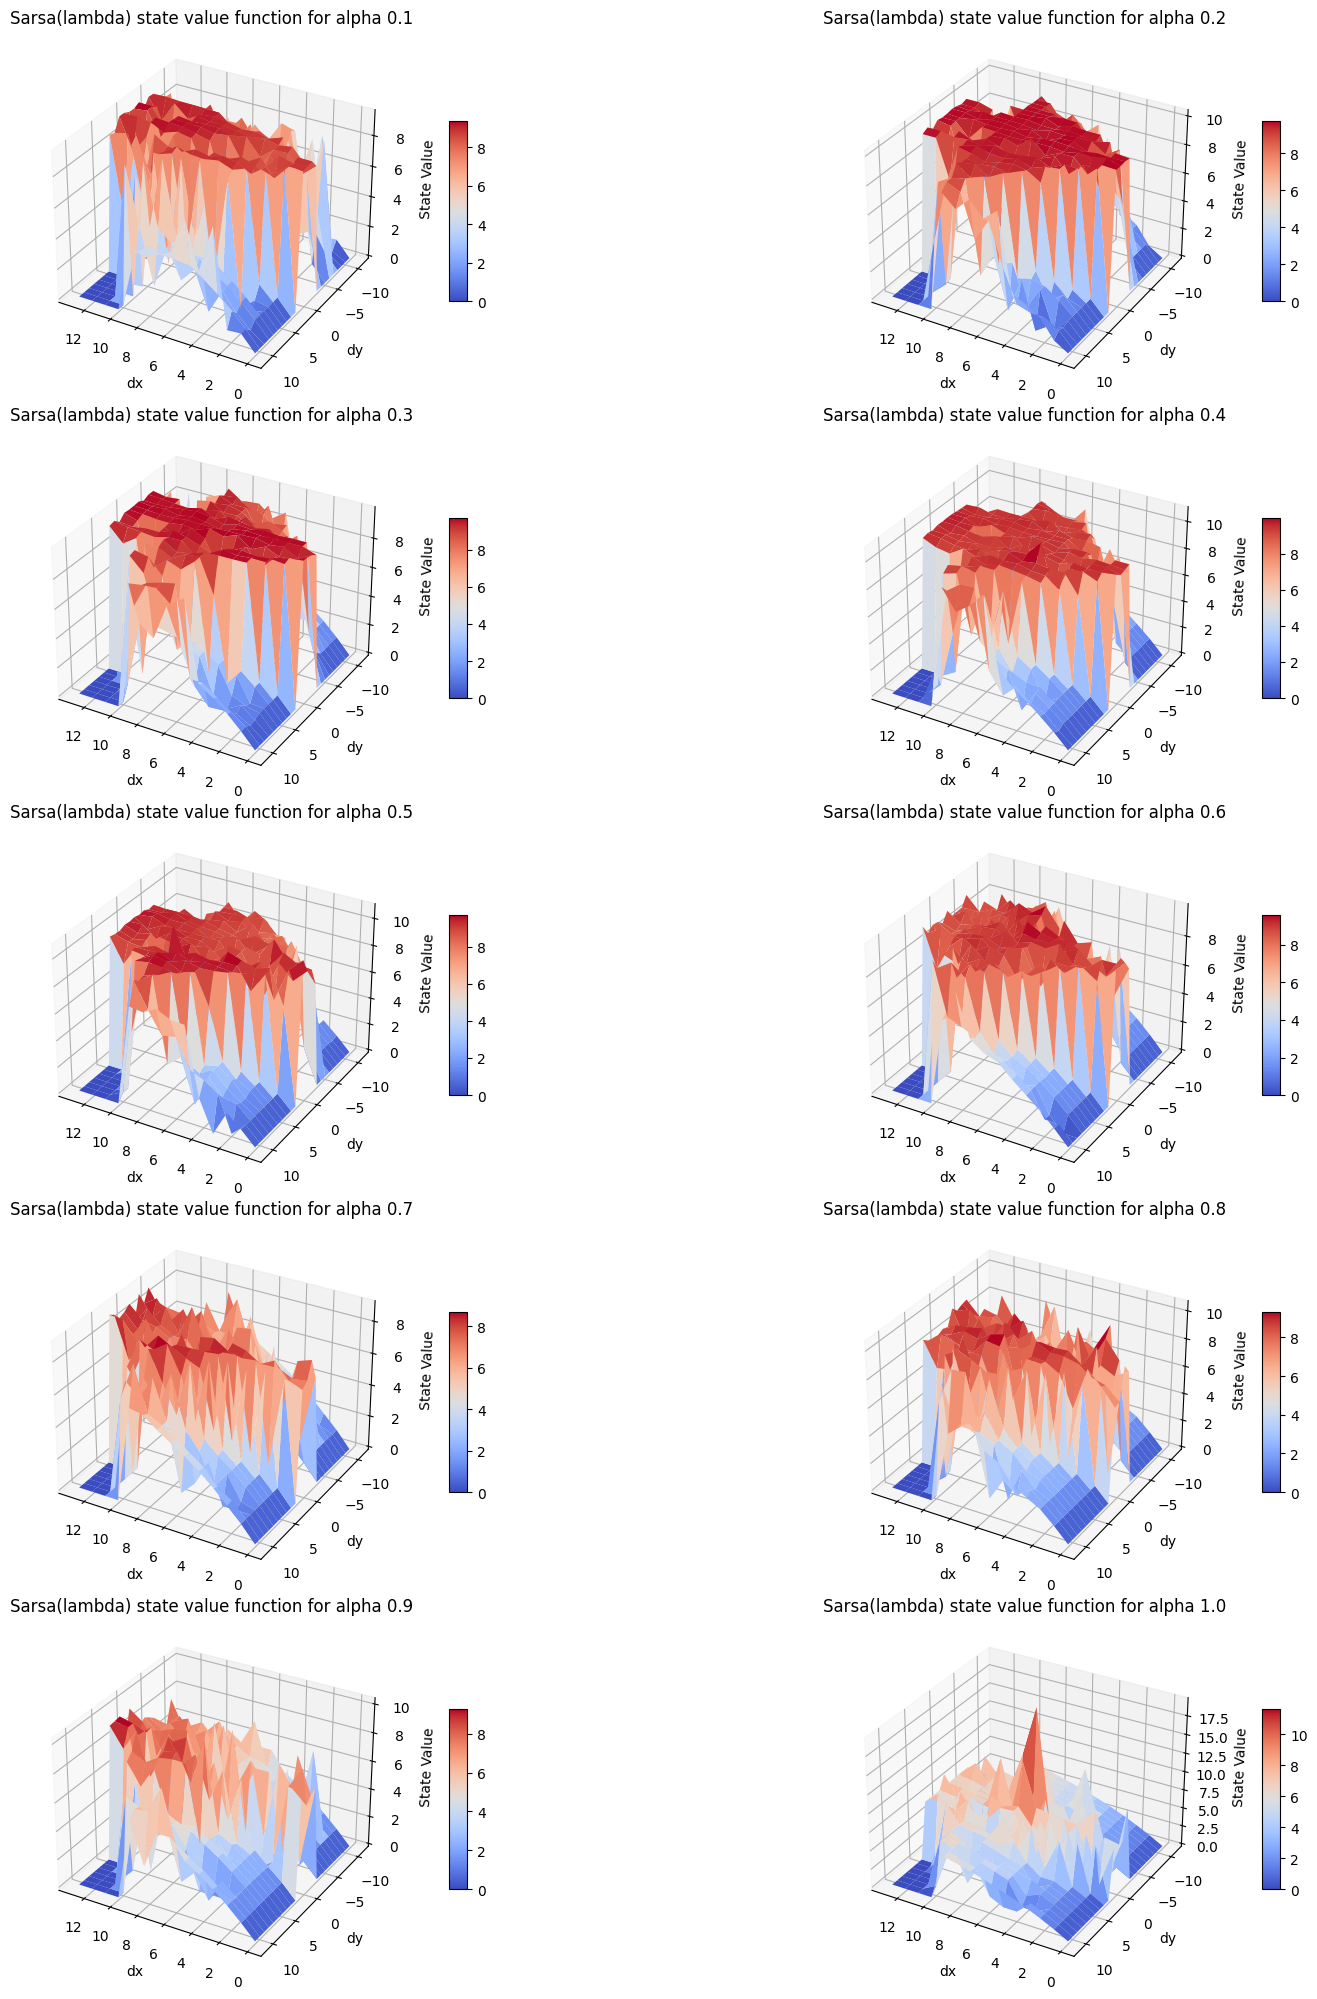

In [127]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})

axs = axs.flatten()
for i, al in enumerate(alphas):
    V = np.max(sarsa_alphas_weights[al], axis=0)
    ax = axs[i]
    ax.set_xlabel("dx")
    ax.set_ylabel("dy")
    ax.set_zlabel("State Value")
    ax.set_title(f"Sarsa(lambda) state value function for alpha {al}")
    ax.view_init(ax.elev, 120)
    surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

In [99]:
sarsa_gammas_steps = {}
sarsa_gammas_scores = {}
sarsa_gammas_weights = {}

for g in gammas:
    sarsa_agent_gamma = Sarsa_Lambda_Agent()
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    sarsa_agent_gamma.initialize_agent({"gamma": g})
    eps_steps = []
    eps_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = sarsa_agent_gamma.run_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
    sarsa_gammas_steps[g] = np.array(eps_steps)
    sarsa_gammas_scores[g] = np.array(eps_score)
    sarsa_gammas_weights[g] = np.array(sarsa_agent_gamma.weights)

100%|██████████| 7000/7000 [00:05<00:00, 1197.56it/s]


In [100]:
print("Results of Parameter Exploration of Gammas (Sarsa Lambda)")
print("------------------------------------------")
print("| Gamma  | Average Steps | Average Score |")
print("------------------------------------------")
for gamma in gammas:
    print(f"| {gamma} \t | {np.mean(sarsa_gammas_steps[gamma]):.3f} \t | {np.mean(sarsa_gammas_scores[gamma]):.3f} \t |")
print("------------------------------------------")

Results of Parameter Exploration of Gammas (Sarsa Lambda)
------------------------------------------
| Gamma  | Average Steps | Average Score |
------------------------------------------
| 0.1 	 | 42.507 	 | 3.086 	 |
| 0.2 	 | 42.013 	 | 2.993 	 |
| 0.3 	 | 48.535 	 | 3.654 	 |
| 0.4 	 | 64.674 	 | 5.243 	 |
| 0.5 	 | 62.889 	 | 5.095 	 |
| 0.6 	 | 58.516 	 | 4.672 	 |
| 0.7 	 | 77.602 	 | 6.600 	 |
| 0.8 	 | 63.591 	 | 5.174 	 |
| 0.9 	 | 77.206 	 | 6.558 	 |
| 1.0 	 | 68.941 	 | 5.749 	 |
------------------------------------------


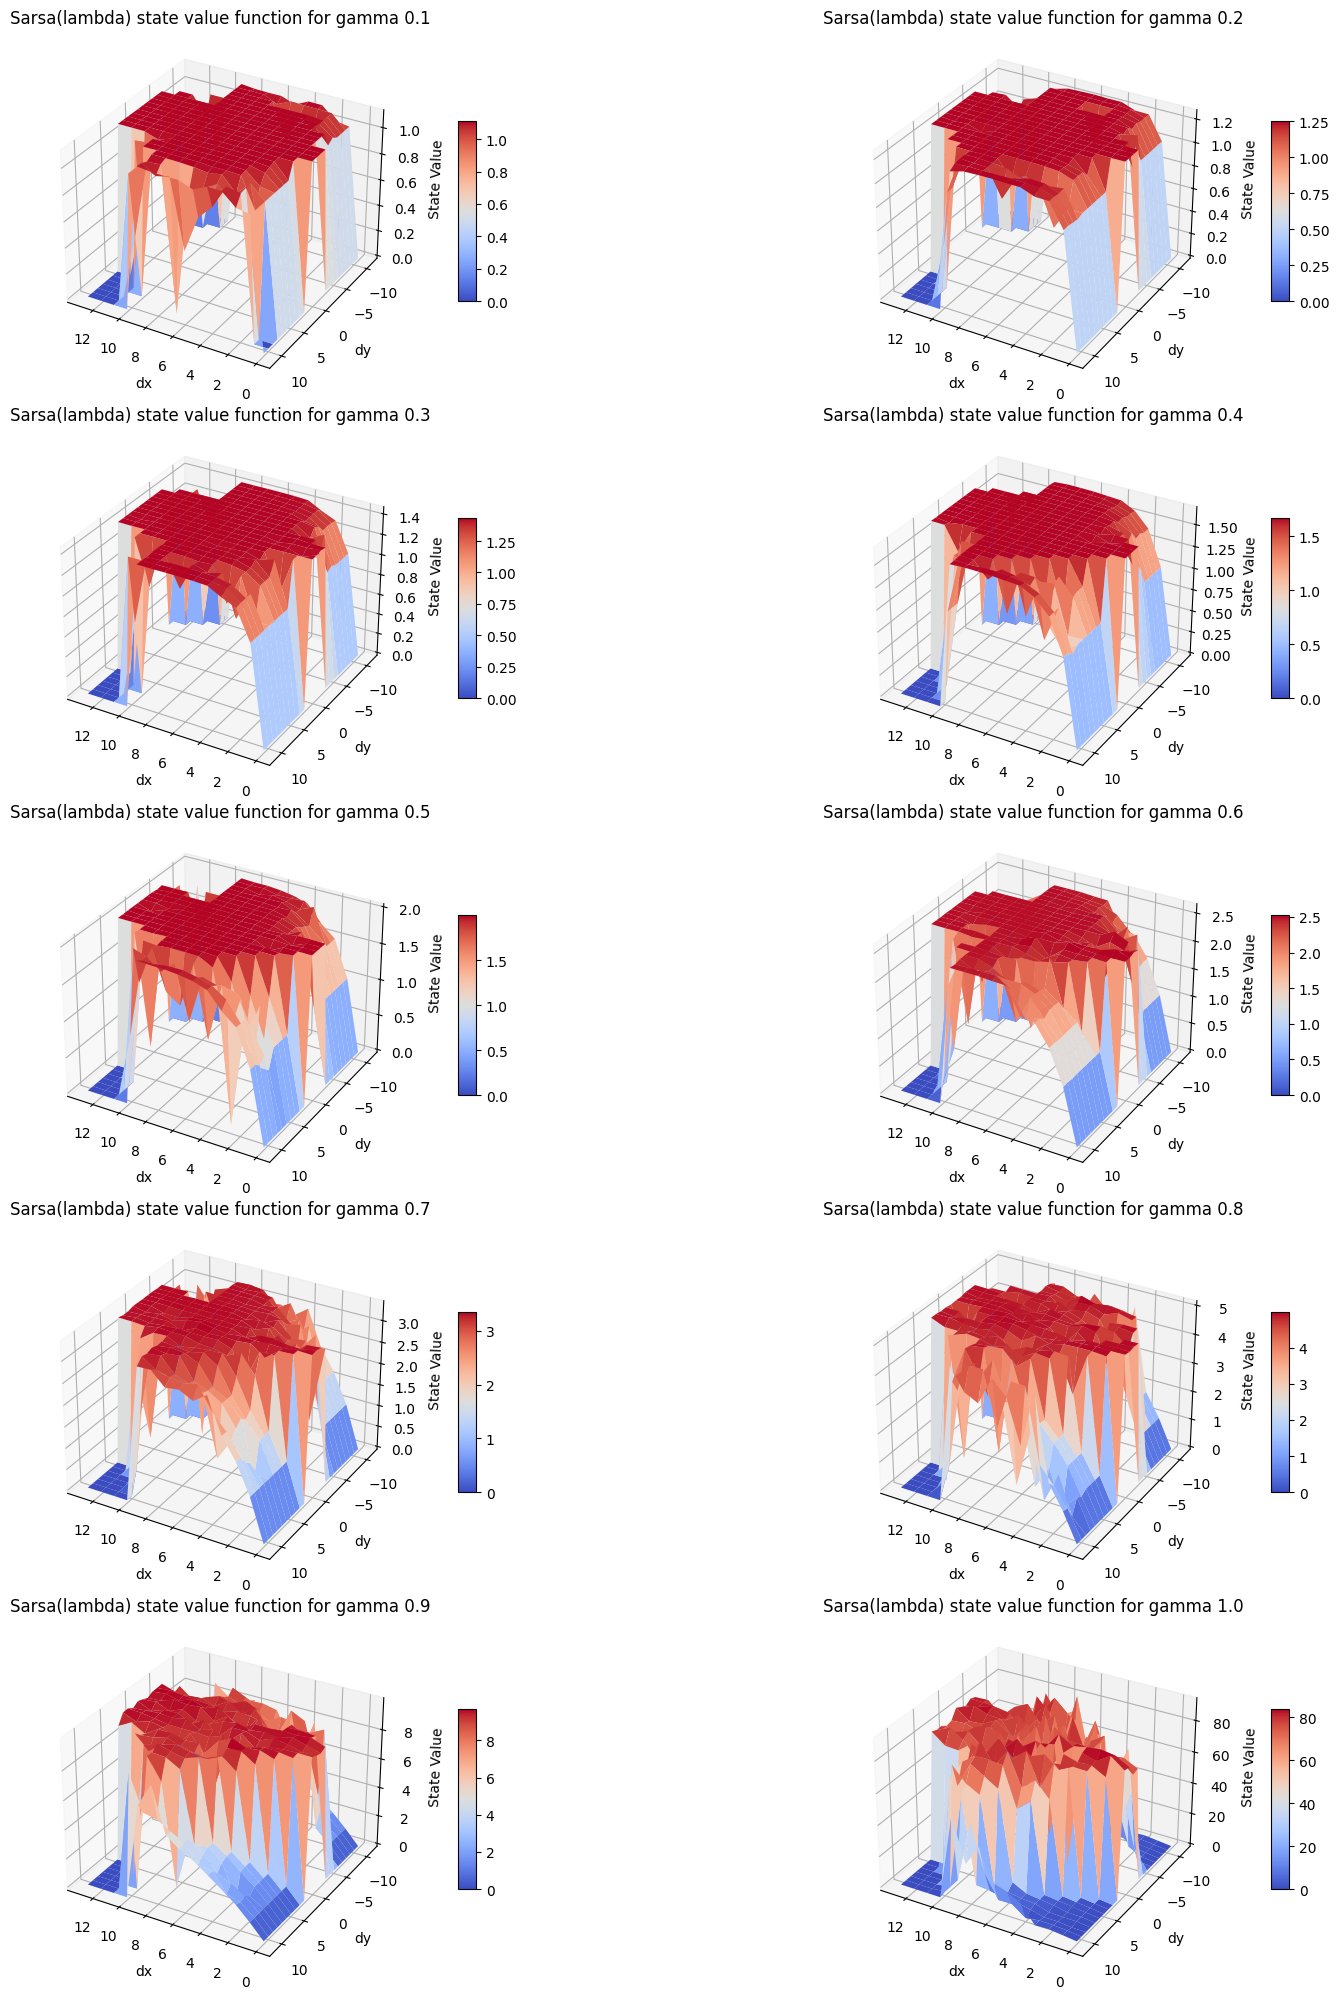

In [101]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})

axs = axs.flatten()

for i, g in enumerate(gammas):
    V = np.max(sarsa_gammas_weights[g], axis=0)
    ax = axs[i]
    ax.set_xlabel("dx")
    ax.set_ylabel("dy")
    ax.set_zlabel("State Value")
    ax.set_title(f"Sarsa(lambda) state value function for gamma {g}")
    ax.view_init(ax.elev, 120)
    surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()

plt.show()

In [106]:
sarsa_lambdas_steps = {}
sarsa_lambdas_scores = {}
sarsa_lambdas_weights = {}

for l in lambdas:
    sarsa_agent_lambda = Sarsa_Lambda_Agent()
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    sarsa_agent_lambda.initialize_agent({"gamma": l})
    eps_steps = []
    eps_score = []
    for ep in tqdm(range(n_episodes)):
        episode, score = sarsa_agent_lambda.run_episode(env)
        eps_steps.append(len(episode))
        eps_score.append(score)
    sarsa_lambdas_steps[l] = np.array(eps_steps)
    sarsa_lambdas_scores[l] = np.array(eps_score)
    sarsa_lambdas_weights[l] = np.array(sarsa_agent_lambda.weights)

100%|██████████| 7000/7000 [00:06<00:00, 1153.21it/s]


In [107]:
print("Results of Parameter Exploration of Lambdas (Sarsa Lambda)")
print("------------------------------------------")
print("| Lambda  | Average Steps | Average Score |")
print("------------------------------------------")
for l in lambdas:
    print(f"| {l} \t | {np.mean(sarsa_lambdas_steps[l]):.3f} \t | {np.mean(sarsa_lambdas_scores[l]):.3f} \t |")
print("------------------------------------------")

Results of Parameter Exploration of Lambdas (Sarsa Lambda)
------------------------------------------
| Lambda  | Average Steps | Average Score |
------------------------------------------
| 0.1 	 | 31.958 	 | 2.017 	 |
| 0.2 	 | 57.341 	 | 4.577 	 |
| 0.3 	 | 52.898 	 | 4.074 	 |
| 0.4 	 | 58.697 	 | 4.661 	 |
| 0.5 	 | 62.795 	 | 5.082 	 |
| 0.6 	 | 65.351 	 | 5.357 	 |
| 0.7 	 | 72.607 	 | 6.047 	 |
| 0.8 	 | 72.836 	 | 6.089 	 |
| 0.9 	 | 80.664 	 | 6.904 	 |
| 1.0 	 | 71.538 	 | 6.008 	 |
------------------------------------------


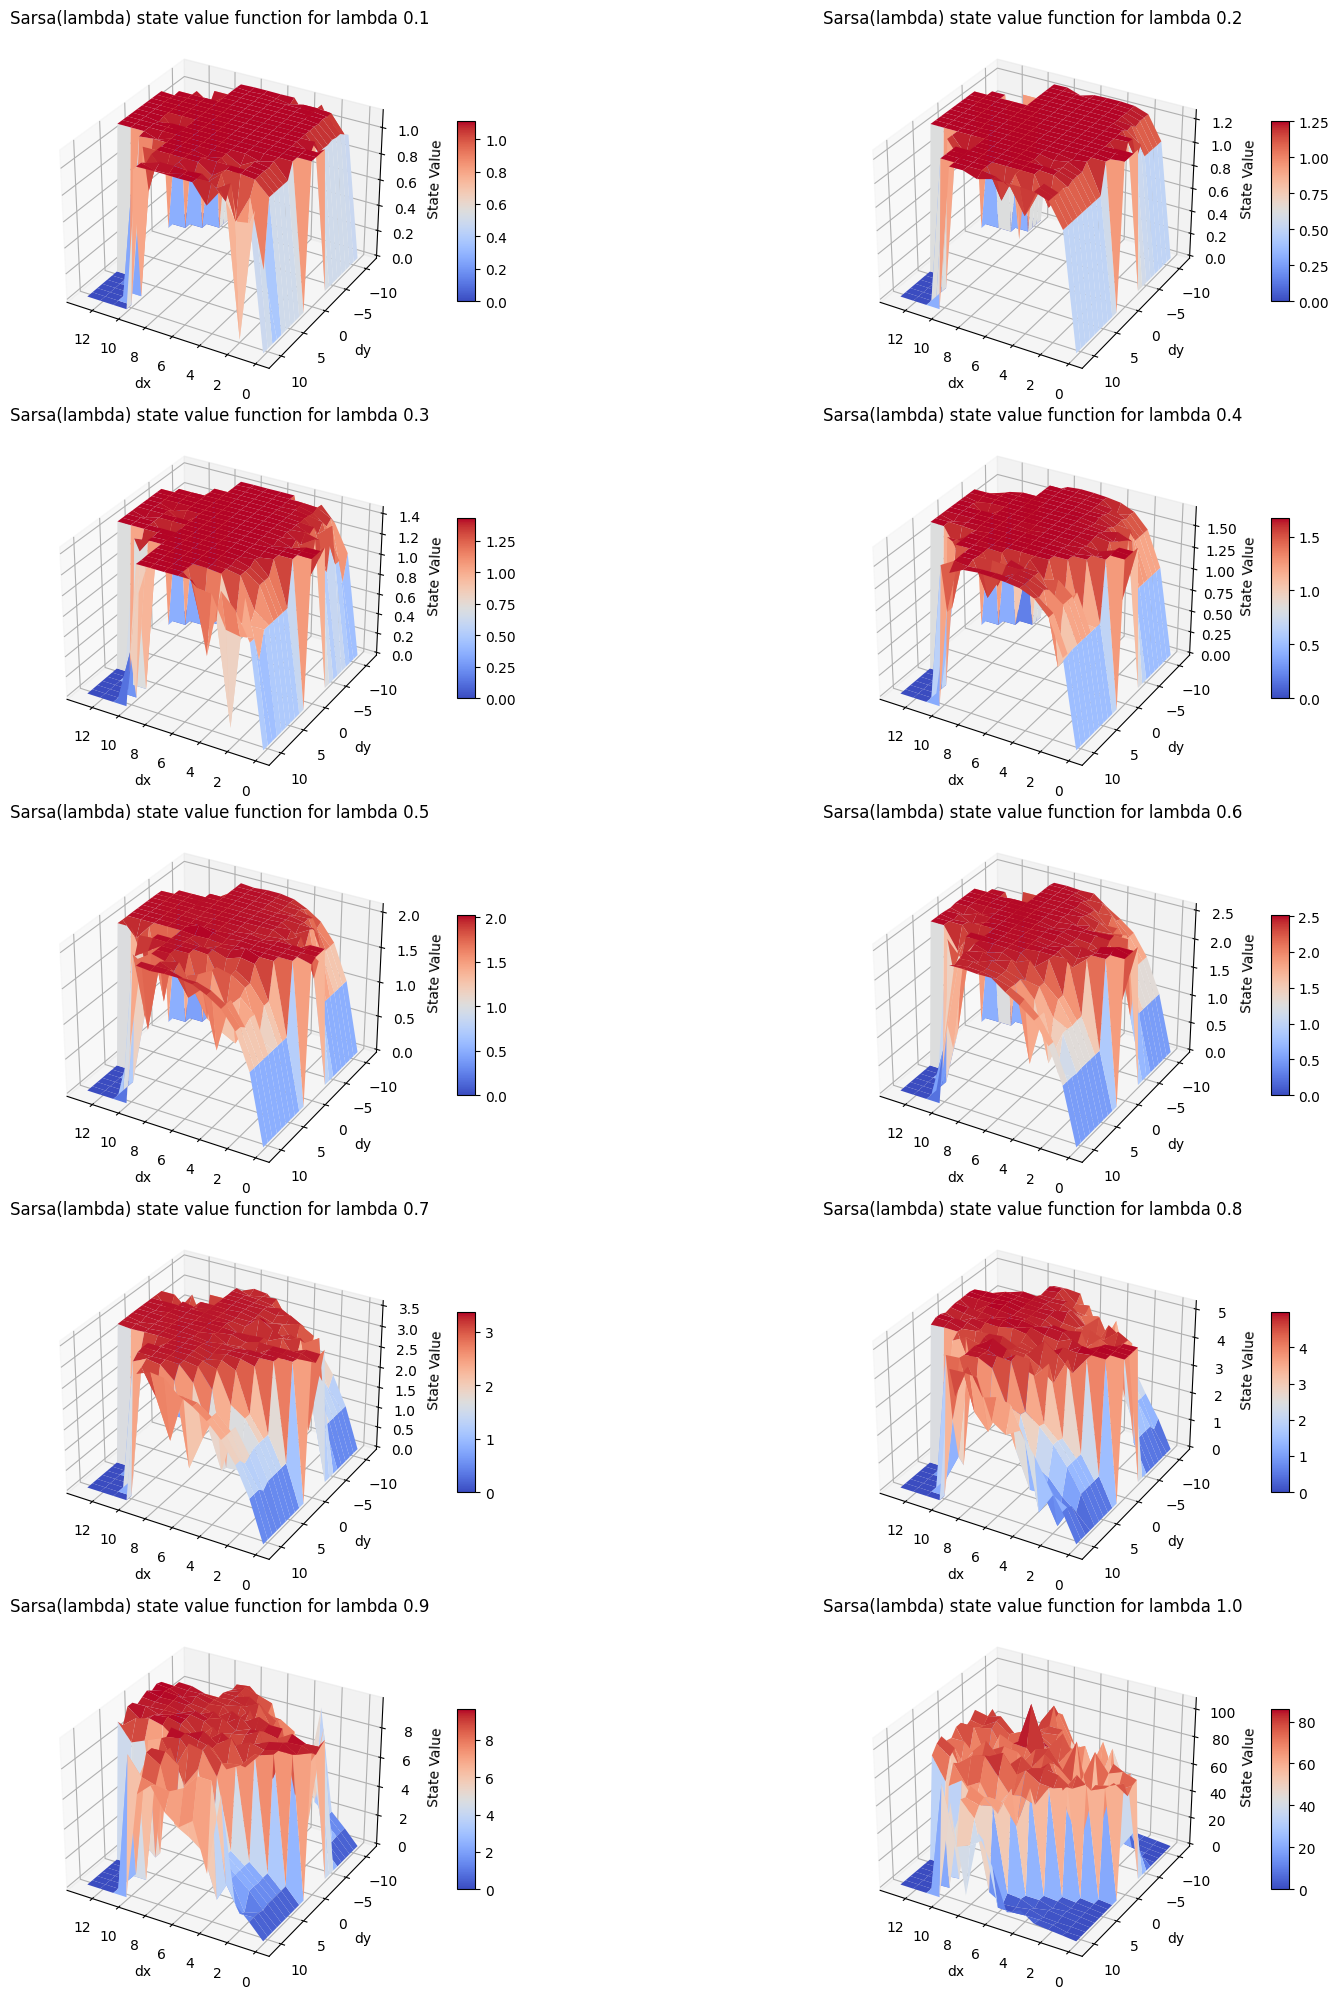

In [128]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})

axs = axs.flatten()
for i, l in enumerate(lambdas):
    if i >= len(axs):  # In case there are more lambdas than subplots, break the loop
        break
    V = np.max(sarsa_lambdas_weights[l], axis=0)
    ax = axs[i]
    ax.set_xlabel("dx")
    ax.set_ylabel("dy")
    ax.set_zlabel("State Value")
    ax.set_title(f"Sarsa(lambda) state value function for lambda {l}")
    ax.view_init(ax.elev, 120)
    surf = ax.plot_surface(X, Y, V[X, Y], cmap=plt.cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

## Other Environments

In [212]:
def testing(agent, env):
    steps = 0
    score = 0
    obs, _ = env.reset()
    done = False
    while not done:
        action = agent.trained_agent_policy(obs)

        obs, reward, done, _, info = env.step(action)
        
        score = info["score"]
        steps += 1
        
    env.close()
    return steps, score

In [206]:
episodes = 3000
test_steps = {}
test_scores = {}
env_configs = [{"height": 6, "width": 15, "pipe_gap": 2}, {"height": 15, "width": 10, "pipe_gap": 7}]
agents = [mc_agent, sarsa_agent]
agents_name = {mc_agent: "Monte Carlo", sarsa_agent: "Sarsa Lambda"}

for ag in agents:
    name = agents_name[ag]
    test_steps[name] = {} 
    test_scores[name] = {} 
    for i, conf in enumerate(env_configs):
        env = gym.make('TextFlappyBird-v0', height=conf["height"], width=conf["width"], pipe_gap=conf["pipe_gap"])
        eps_steps = []
        eps_score = []
        for ep in tqdm(range(episodes)):
            step, score = testing(sarsa_agent, env)
            eps_steps.append(step)
            eps_score.append(score)
        test_steps[name][i] = np.array(eps_steps)
        test_scores[name][i] = np.array(eps_score)

100%|██████████| 3000/3000 [00:01<00:00, 2475.99it/s]


In [216]:
for ag in agents:
    name = agents_name[ag]
    print(f"\t\t   {name}")
    print("-------------------------------------------------")
    print("| Configuration | Average steps | Average score |")
    print("-------------------------------------------------")
    for i, config in enumerate(env_configs):
        print(f"| {i+1} \t\t| {np.mean(test_steps[name][i]):.3f} \t | {np.mean(test_scores[name][i]):.3f} \t|")
    print("-------------------------------------------------")
    print("")

		   Monte Carlo
-------------------------------------------------
| Configuration | Average steps | Average score |
-------------------------------------------------
| 1 		| 13.573 	 | 0.488 	|
| 2 		| 26.749 	 | 4.152 	|
-------------------------------------------------

		   Sarsa Lambda
-------------------------------------------------
| Configuration | Average steps | Average score |
-------------------------------------------------
| 1 		| 13.723 	 | 0.506 	|
| 2 		| 27.070 	 | 4.219 	|
-------------------------------------------------

